In [1]:
from repalette.lightning.systems import AdversarialMSESystem, PreTrainSystem

In [2]:
generator = PreTrainSystem.load_from_checkpoint("/home/dan/Projects/repalette/data/model-checkpoints/pretrain.ckpt").generator

In [37]:
from PIL import Image

image = Image.open("images/iphone.jpeg").convert("RGB")

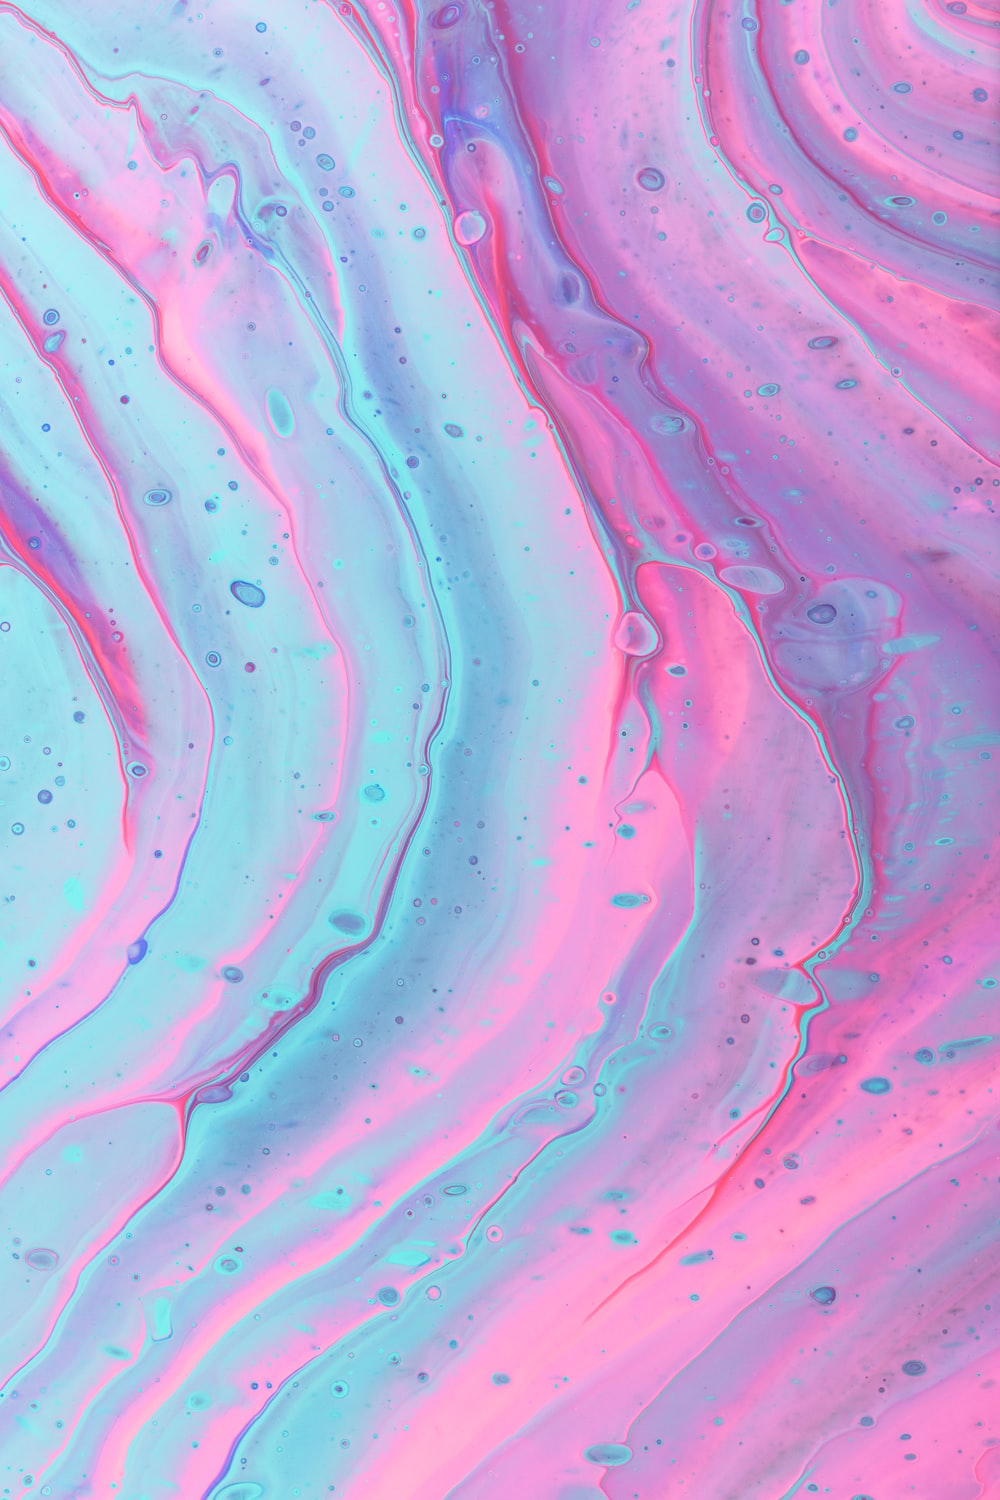

In [38]:
image

In [39]:
from PIL import ImageColor
import numpy as np
from matplotlib import pyplot as plt

nord_palette = [
    "#B48EAD", "#5E81AC", "#88C0D0", "#A3BE8C", "#EBCB8B", "#D08770",
]

red_violet_palette =  [
    "#bc1237", "#bc3e6e", "#ff77f1", "#ffaaff", "#aa4133", "#aa6363"
]

green_blue_palette = [
    "#55ff7f", "#55ffff", "#55ff00", "#beff31", "#c5ffaa", "#b2eeff"
]

In [40]:
palette = green_blue_palette

In [41]:
palette = Image.fromarray(np.array(
            [ImageColor.getcolor(color, "RGB") for color in palette]
        ).reshape((1, 6, 3)).astype("uint8"))

plt.imshow(palette)

In [42]:
from PIL import Image
from skimage.color import lab2rgb, rgb2lab
import torch
from torchvision.transforms.functional import to_tensor
from torchvision import transforms

from repalette.utils.transforms import LABNormalizer
from repalette.constants import DEFAULT_IMAGE_SIZE
from repalette.utils.transforms import smart_hue_adjust



def recolor_image(image, palette, generator, image_size=None):
    generator.eval()
    
    normalizer = LABNormalizer()
    
    if image_size is None:
        image_size = image.size[1], image.size[0]

    image_transform = transforms.Compose([
        transforms.Resize(image_size),
    ])
    
    palette_transform = transforms.Compose([
    ])
    
    image_transformed = image_transform(image)
    palette_transformed = palette_transform(palette)
    
    image_lab = rgb2lab(image_transformed)
    palette_lab = rgb2lab(palette_transformed)
    
    image_tensor = to_tensor(image_lab).float()
    palette_tensor = to_tensor(palette_lab).float()
    
    image_normalized = normalizer.normalize(image_tensor).unsqueeze(0)
    palette_normalized = normalizer.normalize(palette_tensor).view(1, -1)
        
    recolored_image_ab = generator(image_normalized, palette_normalized).detach().cpu()

    original_luminance = image_normalized.clone()[:, 0:1, ...]
    recolored_img_lab_normalized = torch.cat(
        (
            original_luminance,
            recolored_image_ab,
        ),
        dim=1,
    )
    recolored_image_lab = normalizer.inverse_transform(
        recolored_img_lab_normalized
    )
    recolored_image = lab2rgb(recolored_image_lab.squeeze(0).permute(1, 2, 0))
                                         
    recolored_image = Image.fromarray((recolored_image * 255).astype("uint8").reshape(image_size[0], image_size[1], 3))
    
    return recolored_image

In [43]:
recolored_image = recolor_image(image, palette, generator)#, image_size=(1920, 1080))

In [44]:
recolored_image

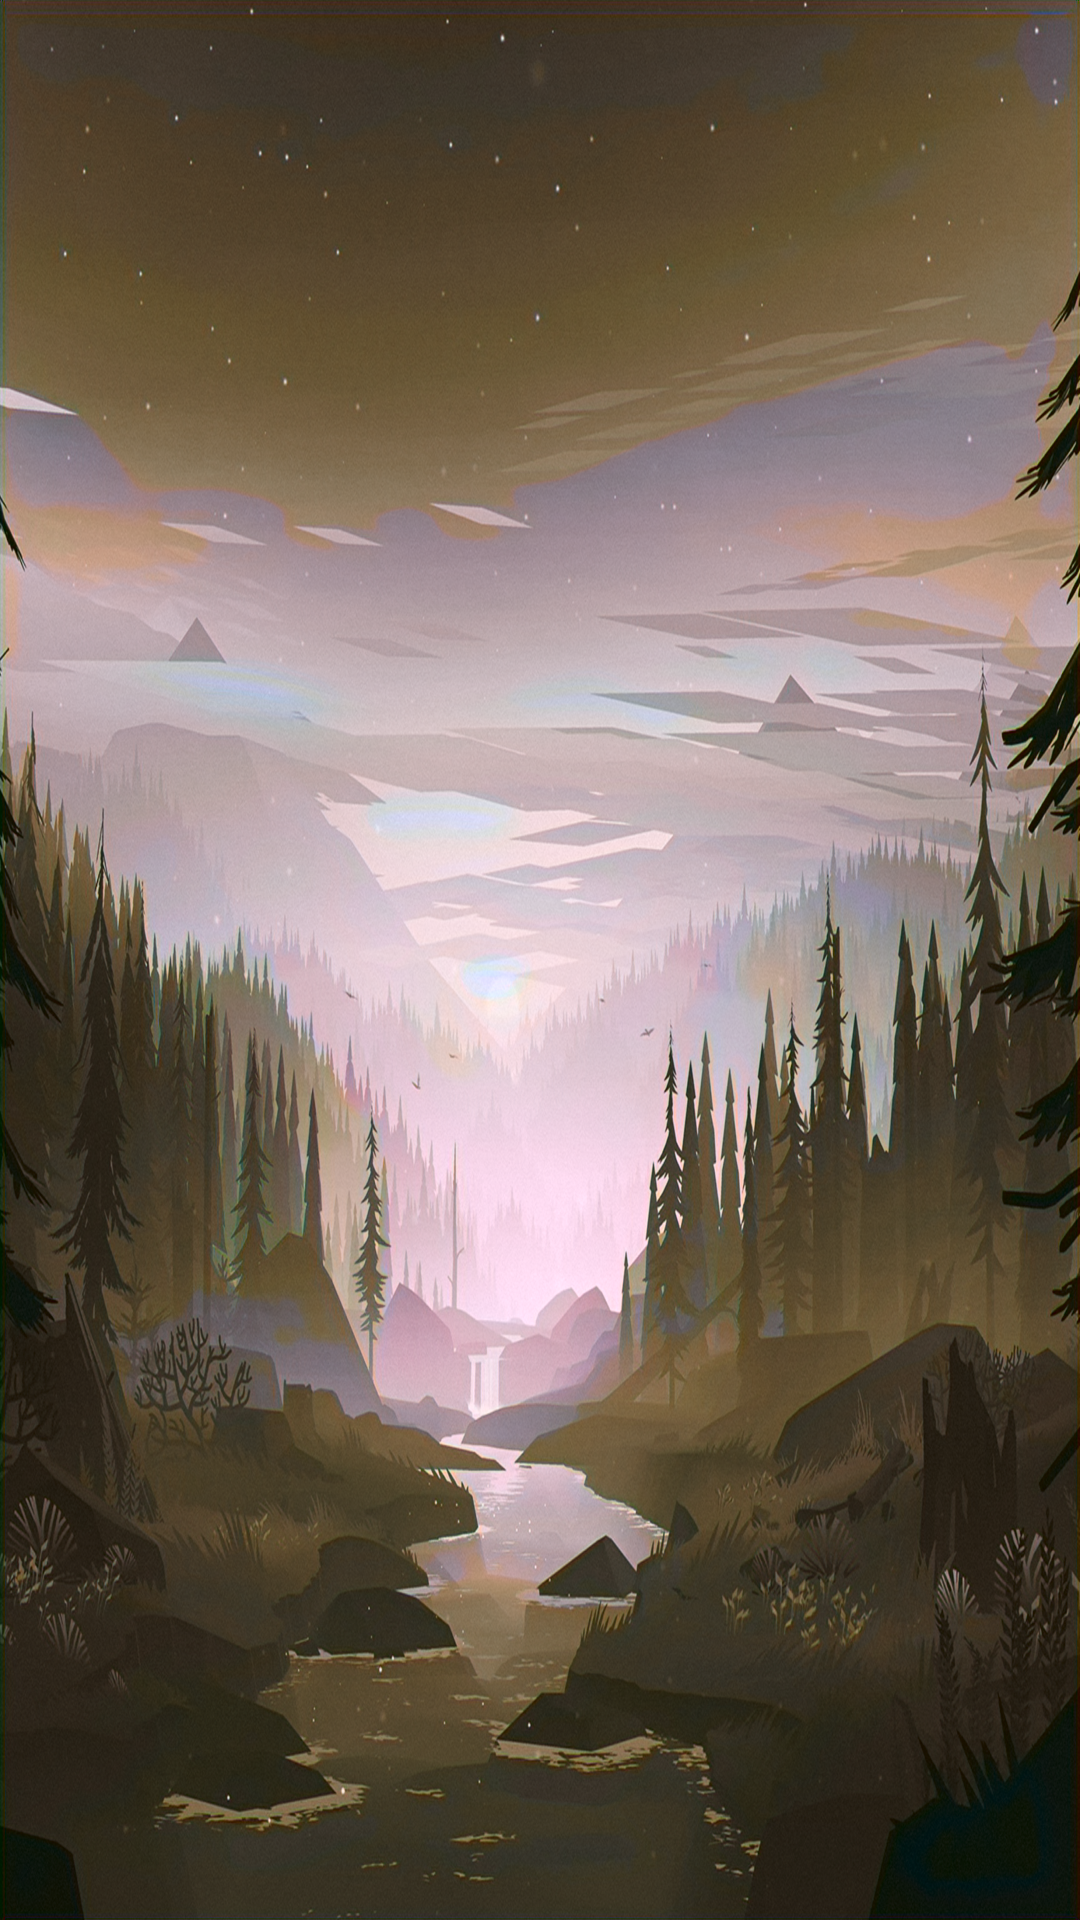

In [10]:
recolored_image

In [11]:
recolored_image.save("recolored.png")